## Turnstile NoteBook: Adam, Andrée, Iggy, and Laila 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

### Importing data

In [2]:
dates = ["180922.txt","180915.txt","180908.txt","180901.txt","180825.txt","180818.txt","180811.txt","180804.txt","180728.txt","180721.txt","180714.txt","180707.txt","180630.txt","180623.txt","180616.txt","180609.txt","180602.txt"]
data = []
df = pd.DataFrame()
for date in dates:
    link = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + date
    data.append(pd.read_csv(link))
df = pd.concat(data)

### Cleaning the data

In [3]:
# Removing blank spaces in namea
df.columns = [column.strip() for column in df.columns]

In [4]:
# Converting to datetime
df['DATETIME'] = pd.to_datetime(df['DATE'].apply(str)+" "+df['TIME'])

#Make date col datetime obj for later use
df['DATE'] = pd.to_datetime(df['DATE'],format="%m/%d/%Y")
df['Day of the Week'] = df['DATE'].dt.day_name()
df['Week #'] = df['DATE'].dt.week
df['HOUR']=df['DATETIME'].dt.hour

In [5]:
# Clean intermediate hours
def bucket_time(time):
    timelist = [1,2,3,4,5,6,7]
    if time > '20:00:00':
        bucket = '6 8pm-12am'
    elif time > '16:00:00':
        bucket = '5 4-8pm'
    elif time >'12:00:00':
        bucket= '4 12-4pm'
    elif time > '08:00:00':
        bucket = '3 8am-12pm'
    elif time > '04:00:00':
        bucket = '2 4-8am'
    else:
        bucket = '1 0-4am'
    return bucket
    
df['Time Bucket'] = df['TIME'].apply(lambda x:bucket_time(x))

In [6]:
# Creating unique turnstile variable
df['UNIQUE ID'] = df['C/A']+df['UNIT']+df['SCP']+df['STATION']

# Creating unique station variable
df['LINENAME'] = df['LINENAME'].apply(lambda x: ''.join(sorted(x)))
df['UNIQUESTATION'] = df['STATION']+" "+df['LINENAME']

In [7]:
df=df.sort_values(by=['UNIQUE ID','DATETIME'])

# abs value to take turnstiles that ran in reverse
df['ENTRIES_COUNT']=abs(df['ENTRIES'].diff())
df['FIRST'] = df.groupby('UNIQUE ID').cumcount()

# get rid of initial time differences
df = df[df['FIRST'] != 0]

# get rid of extreme values
df = df[abs(df['ENTRIES_COUNT']) < 10000]

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,Day of the Week,Week #,HOUR,Time Bucket,UNIQUE ID,UNIQUESTATION,ENTRIES_COUNT,FIRST
1,A002,R051,02-00-00,59 ST,456NQRW,BMT,2018-05-26,04:00:00,REGULAR,6633916,2248500,2018-05-26 04:00:00,Saturday,21,4,1 0-4am,A002R05102-00-0059 ST,59 ST 456NQRW,18.0,1
2,A002,R051,02-00-00,59 ST,456NQRW,BMT,2018-05-26,08:00:00,REGULAR,6633928,2248517,2018-05-26 08:00:00,Saturday,21,8,2 4-8am,A002R05102-00-0059 ST,59 ST 456NQRW,12.0,2
3,A002,R051,02-00-00,59 ST,456NQRW,BMT,2018-05-26,12:00:00,REGULAR,6634015,2248577,2018-05-26 12:00:00,Saturday,21,12,3 8am-12pm,A002R05102-00-0059 ST,59 ST 456NQRW,87.0,3
4,A002,R051,02-00-00,59 ST,456NQRW,BMT,2018-05-26,16:00:00,REGULAR,6634173,2248610,2018-05-26 16:00:00,Saturday,21,16,4 12-4pm,A002R05102-00-0059 ST,59 ST 456NQRW,158.0,4
5,A002,R051,02-00-00,59 ST,456NQRW,BMT,2018-05-26,20:00:00,REGULAR,6634367,2248645,2018-05-26 20:00:00,Saturday,21,20,5 4-8pm,A002R05102-00-0059 ST,59 ST 456NQRW,194.0,5


### Data Exploration 

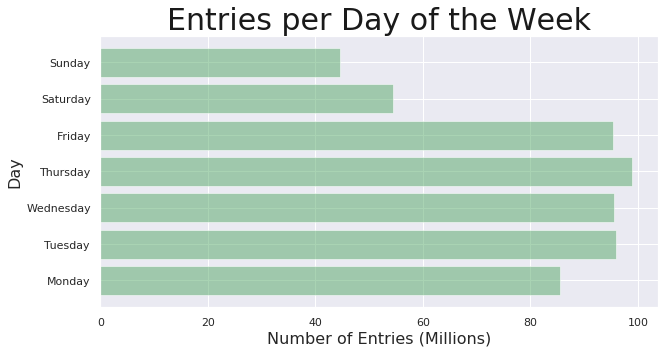

In [8]:
df_days = df.groupby(['Day of the Week'])['ENTRIES_COUNT'].sum().sort_values().reset_index()

days = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
df_days['rank'] = df_days['Day of the Week'].map(days,df_days['Day of the Week'])
df_days = df_days.sort_values(by='rank')
df_days

sns.set()
plt.figure(figsize=(10,5))
plt.barh(df_days['Day of the Week'],(df_days['ENTRIES_COUNT'])/1000000,color='g',alpha=0.5);
plt.title('Entries per Day of the Week',fontsize = 30,color='k',loc='center');
plt.xlabel('Number of Entries (Millions)',fontsize = 16);

plt.ylabel('Day',fontsize = 16);

Text(0.5, 1.0, 'Entries by station (Top 40)')

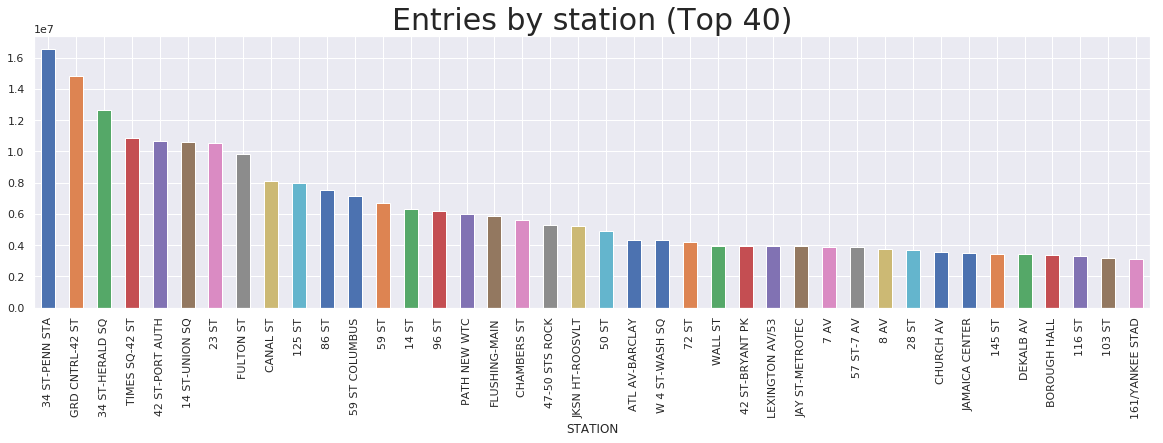

In [9]:
df_station = df.groupby(["STATION"])["ENTRIES_COUNT"].sum().sort_values(ascending = False)

sns.set()
plt.figure(figsize = (20,5))
df_station.iloc[0:40].plot.bar()
plt.title('Entries by station (Top 40)',fontsize=30)

### Top 10 stations

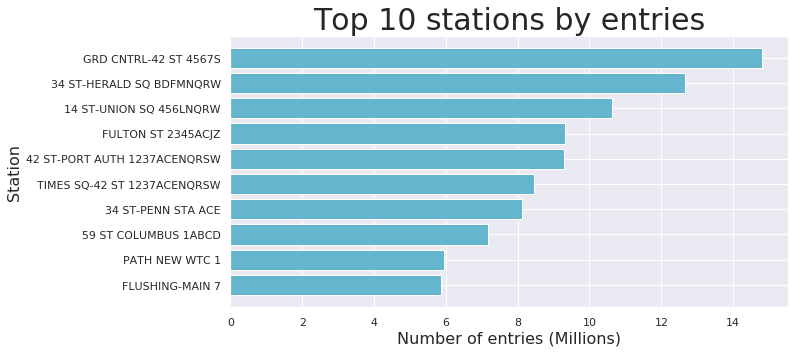

In [10]:
Topstations = df.groupby(["UNIQUESTATION"])["ENTRIES_COUNT"].sum().sort_values(ascending=False).head(10)

Topstations = Topstations.sort_values(ascending = True).reset_index()

sns.set()
plt.figure(figsize=(10,5))
plt.barh(Topstations['UNIQUESTATION'],Topstations['ENTRIES_COUNT']/1000000, color='c')
plt.title('Top 10 stations by entries',fontsize='30')
plt.xlabel('Number of entries (Millions)',fontsize = 16);
plt.ylabel('Station',fontsize = 16);

In [11]:
dftop=df[df['UNIQUESTATION'].isin(Topstations['UNIQUESTATION'])]

In [12]:
# After google banning us from using maps API, added zip codes by hand. See apendix
topzip = pd.DataFrame(
    {'UNIQUESTATION':
     ['FLUSHING-MAIN 7','PATH NEW WTC 1','59 ST COLUMBUS 1ABCD','34 ST-PENN STA ACE','TIMES SQ-42 ST 1237ACENQRSW',
      '42 ST-PORT AUTH 1237ACENQRSW','FULTON ST 2345ACJZ','14 ST-UNION SQ 456LNQRW','34 ST-HERALD SQ BDFMNQRW',
      'GRD CNTRL-42 ST 4567S'],
    'Zip':
     [11354,10007,10023,10001,10036,10036,10038,10003,10001,10017]
})

dftop = pd.merge(dftop,topzip,on='UNIQUESTATION',how='outer')

In [13]:
# Clean the names of the stations for plotting
dftop['all']=dftop['UNIQUESTATION'].str.rsplit(' ', 1)
dftop[['UNIQUESTATION_CLEAN','other']] = pd.DataFrame(dftop['all'].values.tolist())

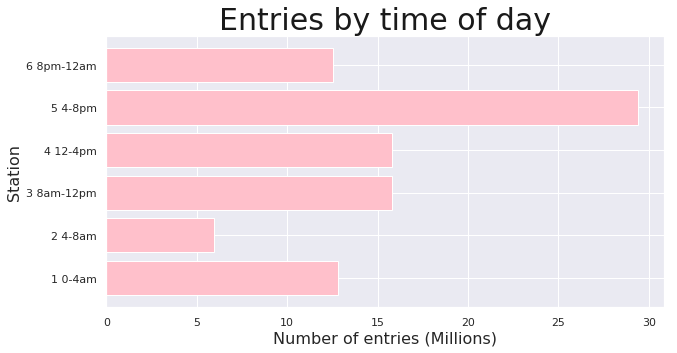

In [14]:
top_hour = dftop.groupby(['Time Bucket'])['ENTRIES_COUNT'].sum().reset_index()
sns.set()
plt.figure(figsize=(10,5))
plt.barh(top_hour['Time Bucket'],top_hour['ENTRIES_COUNT']/1000000, color='pink')
plt.title('Entries by time of day',fontsize = 30,color='k',loc='center')
plt.xlabel('Number of entries (Millions)',fontsize = 16);
plt.ylabel('Station',fontsize = 16);

### Add Music Interest Data

In [15]:
theaters = pd.read_csv("Theaters.csv")
stores = pd.read_csv("Music_Stores.csv")
venues = pd.read_csv("Classical_Music_Venues.csv")

In [16]:
# Renaming columns to merge
theaters['Zip']=theaters['Postcode']
venues['Zip']=venues['ZIP']

In [17]:
allstores=pd.merge(venues,stores,on='Zip',how='outer')
allstores=pd.merge(allstores,theaters,on='Zip',how='outer')
allstores['Count']=1

storesnumber=allstores.groupby('Zip')['Count'].count().reset_index()


,Zip,Count
0,0.0,1
1,10001.0,18
2,10003.0,1
3,10007.0,6
4,10011.0,1
5,10013.0,2
6,10014.0,1
7,10017.0,12
8,10018.0,1
9,10019.0,60


### Add Income Data

In [18]:
income = pd.read_csv("Av_Income_Zip.csv", encoding = "ISO-8859-1")
income['Zip']=income['Zip Code']

In [19]:
income_stores = pd.merge(storesnumber,income,on='Zip',how='outer')

income_stores = income_stores[['Zip','Count','Avg. Income/Person']]

In [20]:
full = pd.merge(dftop,income_stores,on='Zip',how='left')

full[['People', 'Avg. Income/Person']] = full[['ENTRIES_COUNT', 'Avg. Income/Person']].astype(float)

In [21]:
#full[['UNIQUESTATION','Day of the Week','People','DATETIME','Zip','Count','Avg. Income/Person','Score']]

### Building the ranking system

In [22]:
rank_people = full[['UNIQUESTATION_CLEAN','People']].groupby(by=['UNIQUESTATION_CLEAN']).sum().rank().sort_values(by=['People'],ascending=False)

rank_income_stores = full[['UNIQUESTATION_CLEAN','Avg. Income/Person','Count']].groupby(by=['UNIQUESTATION_CLEAN']).mean().rank()

In [23]:
ranking= pd.merge(rank_people,rank_income_stores,on='UNIQUESTATION_CLEAN')
ranking

,People,Avg. Income/Person,Count
UNIQUESTATION_CLEAN,,,
GRD CNTRL-42 ST,10.0,9.0,5.0
34 ST-HERALD SQ,9.0,4.0,7.5
14 ST-UNION SQ,8.0,7.0,1.0
FULTON ST,7.0,2.0,3.5
42 ST-PORT AUTH,6.0,5.0,9.5
TIMES SQ-42 ST,5.0,6.0,9.5
34 ST-PENN STA,4.0,3.0,7.5
59 ST COLUMBUS,3.0,8.0,3.5
PATH NEW WTC,2.0,10.0,2.0


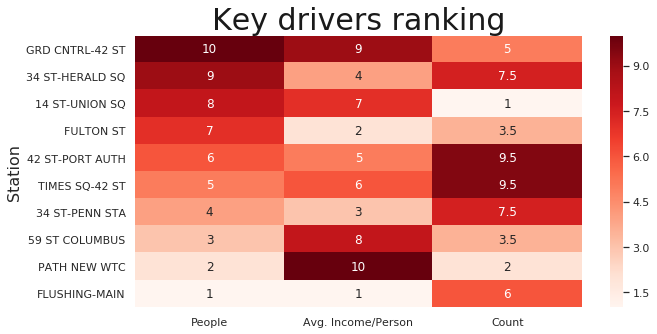

In [24]:
plt.figure(figsize=(10,5))
sns.heatmap(ranking,annot=True, cmap="Reds");
plt.title('Key drivers ranking',fontsize = 30,color='k',loc='center');
plt.ylabel('Station',fontsize = 16);

In [25]:
# Clean the names for the final scoring graph
ranking=ranking.reset_index()
ranking['SCORE'] = (ranking['People']+ranking['Count']+ranking['Avg. Income/Person'])/3
ranking=ranking[['UNIQUESTATION_CLEAN','SCORE']].sort_values(by='SCORE',ascending=True)

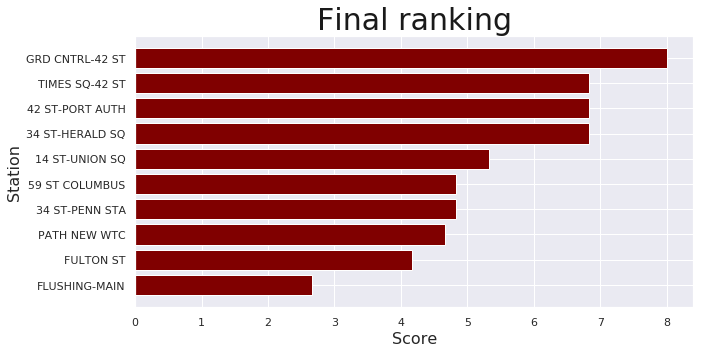

In [26]:
plt.figure(figsize=(10,5))
plt.barh(ranking['UNIQUESTATION_CLEAN'],ranking['SCORE'],color='maroon')
plt.title('Final ranking',fontsize = 30,color='k',loc='center');
plt.xlabel('Score',fontsize = 16);
plt.ylabel('Station',fontsize = 16);

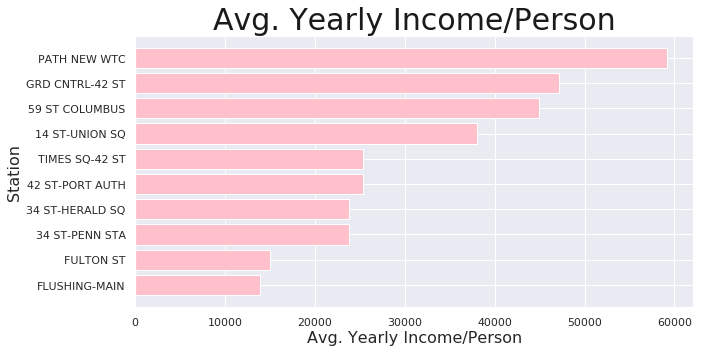

In [27]:
income = full.groupby(by=['UNIQUESTATION_CLEAN'])['Avg. Income/Person'].mean().sort_values(ascending=True).reset_index()
sns.set()
plt.figure(figsize=(10,5))
plt.barh(income['UNIQUESTATION_CLEAN'],income['Avg. Income/Person'],color='pink');
plt.title('Avg. Yearly Income/Person',fontsize = 30,color='k',loc='center');
plt.xlabel('Avg. Yearly Income/Person',fontsize = 16);
plt.ylabel('Station',fontsize = 16);

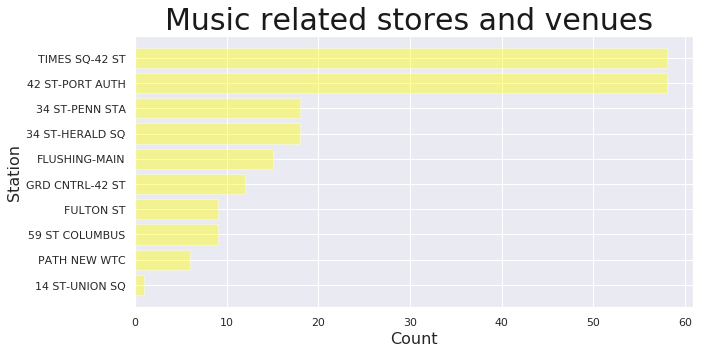

In [28]:
music = full.groupby(by=['UNIQUESTATION_CLEAN'])['Count'].mean().sort_values(ascending=True).reset_index()

sns.set()
plt.figure(figsize=(10,5))
plt.barh(music['UNIQUESTATION_CLEAN'],music['Count'],color='yellow',alpha=0.4);
plt.title('Music related stores and venues ',fontsize = 30,color='k',loc='center');
plt.xlabel('Count',fontsize = 16);
plt.ylabel('Station',fontsize = 16);

## Apendix - not used / failed attempts

In [ ]:
#Try to combine this with other mta data we have
station_loc = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv")
station_loc['Station_Name'] = station_loc['Station_Name'].str.upper()
station_loc.drop(station_loc.columns[5:], axis=1, inplace=True)
station_loc.drop(station_loc.columns[0:2], axis=1, inplace=True)
station_loc = station_loc.rename(columns={'Station_Name': 'STATION'})
#station_loc.head()



#df_merged = pd.merge(df_station,station_loc,on='STATION',how='outer')

#df_station.head()
import difflib



stats=df_station['STATION'].map(lambda x: difflib.get_close_matches(x, station_loc['STATION'], n=1))


stats = [s[0] if s else '' for s in stats]
df_station['NEW STATION'] = stats
df_merged2 = pd.merge(df_station,station_loc,left_on='NEW STATION',right_on='STATION',how='left')
df_merged2.info()

In [ ]:
import requests
def loc_to_zipcode(latitude,longitude):
    sensor = 'true'
    base = "http://maps.googleapis.com/maps/api/geocode/json?"
    params = "latlng={lat},{lon}&sensor={sen}".format(
       lat=latitude,
       lon=longitude,
       sen=sensor
   )
    url = "{base}{params}".format(base=base, params=params)
    while True:
        response = requests.get(url).json()
        if(response['status'] == 'OK'):
            result = response['results'][0]
            break
    return result['address_components'][-1]['long_name']


In [ ]:
loc_to_zipcode(40.775036,-73.912034)

In [ ]:
station_loc = pd.read_csv("http://web.mta.info/developers/data/nyct/subway/StationEntrances.csv")
unique_stat_loc = station_loc.drop_duplicates(['Station_Latitude','Station_Longitude'])
unique_stat_loc = unique_stat_loc[['Station_Latitude','Station_Longitude']].reset_index()

In [ ]:
def split_df(df,n):
    split_df = []
    i = 0
    while True:
        if i+n > len(df)-1:
            split_df.append(df[i:len(df)].reset_index())
            break
        else:
            split_df.append(df[i:i+n].reset_index())
            i += n
    return split_df

split_df = split_df(unique_stat_loc,20)

In [ ]:
import time
test = split_df[0]
zipcodes=[]

for test in split_df[:5]:
    for i in range(len(test['Station_Latitude'])):
        zipcodes.append(loc_to_zipcode(test['Station_Latitude'][i],test['Station_Longitude'][i]))
    time.sleep(300.0)
#zipcodes

In [ ]:
df_totalday=df.groupby('DATE')['ENTRIES_COUNT'].sum()
df_totalday.head()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_totalday.index,df_totalday.values)
plt.title('Total Entries Per Day',family='serif',fontsize = 30,loc='left',color='k');
plt.xlabel('Date');
plt.ylabel('Number of Entries');
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
plots = av.groupby('Week #').plot(y='ENTRIES_COUNT',x='Day of the Week',ax=ax,legend=False, title='Weekly entries by day of the week')